# 🤒 Epidemic mitigation project (Riccardo Brioschi, Francesca Venturi)

This notebook contains the execution code of the *epidemic mitigation process* carried out by Riccardo Brioschi and Francesca Venturi. 

Moreover, not only does it contain the code, it also includes comments and discussions about results, coherently with the requirements of the project.

## Importing useful packages and Initializing the model class

In [1]:
"""Importing useful library"""
import matplotlib.pyplot as plt
from gym import spaces
from helper import *
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from tqdm import tqdm

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch

"""Useful libraries to create directories"""
from os import makedirs
from shutil import rmtree

"""Ignoring warning to make the code more readable"""
import warnings
warnings.filterwarnings('ignore')

# Setting device
device = torch.device('cpu') # torch.device("mps" if torch.backends.mps.is_available() else "cpu")

"""Setting the seeds for reproducibility purposes"""
# We avoid setting the torch seed in order to ensure that the network are initialized in 
# another way after
np.random.seed(42)
random.seed(42)

"""Fixing the seeds for training and evaluation procedure"""
# training seeds
training_seeds = np.random.randint(22, 10000, size=1500)
# evaluation seeds
eval_seeds = np.arange(1, 21)

%matplotlib inline
%load_ext autoreload
%autoreload 2
# %load_ext line_profiler

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map

## Question 1: Study the behaviour of the model when epidemics are unmitigated

We initialize the environment in order to interact with it.

In [3]:
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # Here one could pass an openai gym action space that can then be sampled
            observation_space=None, # Here one could pass an openai gym obs space that can then be sampled
            )

Since the epidemics are unmitigated, in this first task we will always use the null action. Therefore we initialize it in order to call it in the next cells.

In [4]:
ACTION_NULL = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

We now run the epidemic simulation for one episode without epidemic mitigation. We store the results in log to later plot them.

In [5]:
log = []
seed = 1
finished = False
obs, info = env.reset(seed) # here it is not seeded
for t in range(30):
    obs, R, finished, info = env.step(ACTION_NULL) # always same actions
    log.append(info) # save the information dict for logging
    if finished:
        break

""" Parse the logs """
total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

We plot the results. Rather then visualize every single result in different cells, we decide to use the code provided by the teaching team in the tutorial.

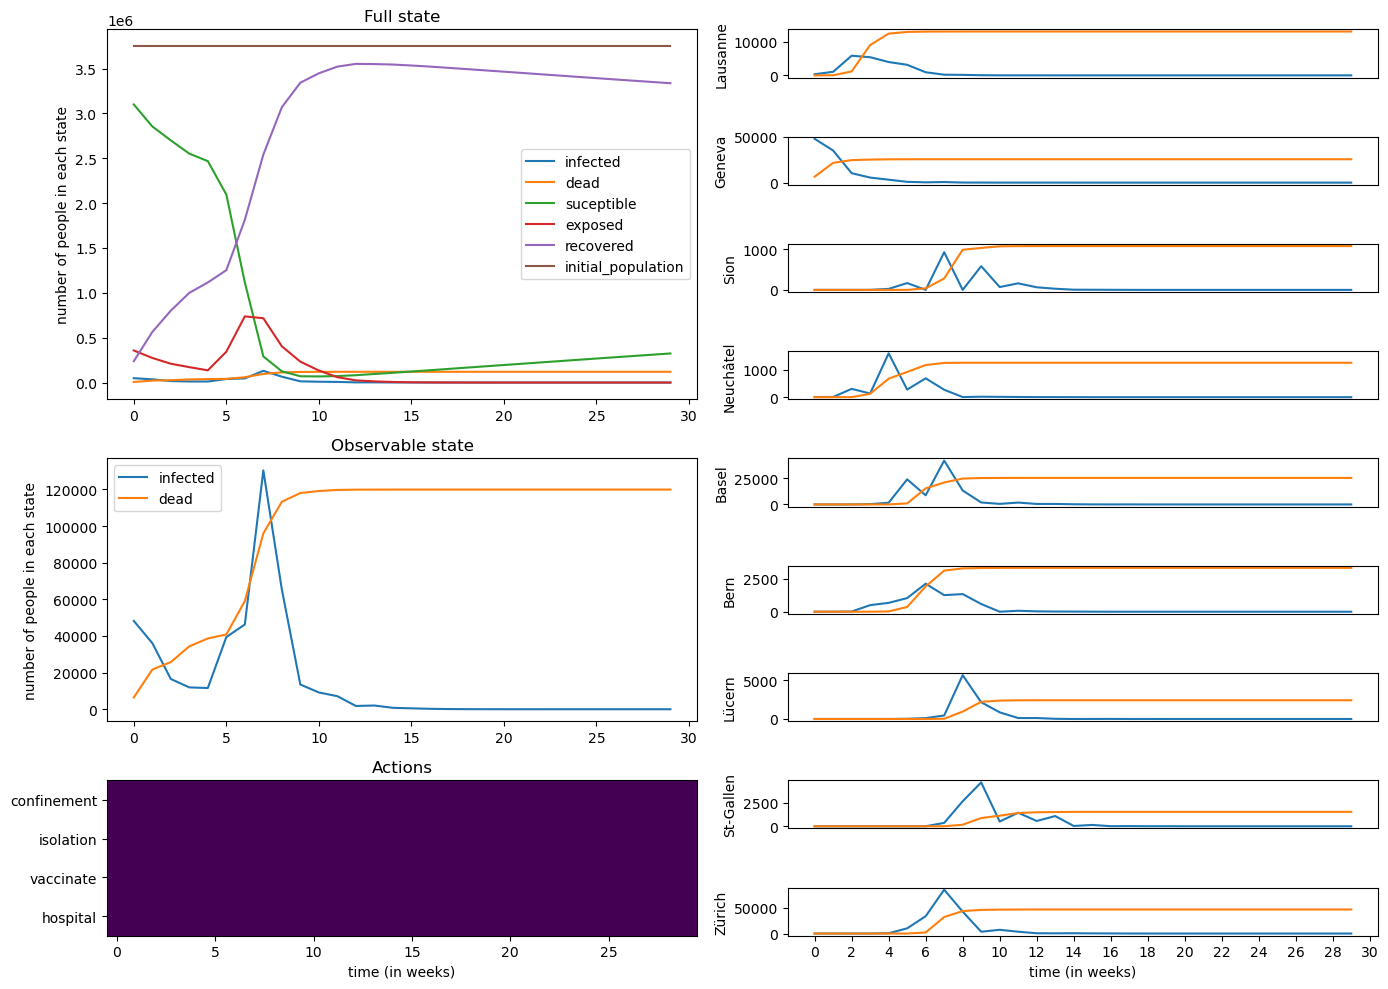

In [6]:
plot_info(total, cities, actions)

## Question 2: Professor Russo's Policy

### Question 2.a: Implement the policy
We implement Pr. Russo’s Policy as a python class (subclass the Agent abstract class provided with the project files) and initialize the agent accordingly. This choice has been made to make the interaction with the initialized environment easier.

Pr. Russo's Policy consists in confining (`ACTION_CONFINE`) the population for 4 weeks once the amount of infected people exceeds 20000 units. The *confinement action* is not debatable during the confinment. This means that the confinments happen in blocks of (at least) 4 weeks each.

In [7]:
class RussoAgent(Agent): # Agent is the superclass
    def __init__(self,  env:Env):
        """
        Initialization of the agent
        """
        self.env = env
        
        # Initializing variables to keep trace of weeks to wait to end confinement
        self.count_remaining_weeks = 0
        
        # Initializing default and confinement action, which are returned by the act method depending
        # on the amount of infected people
        self.default_action  = { # DO NOTHING
                                'confinement': False, 
                                'isolation': False, 
                                'hospital': False, 
                                'vaccinate': False,
                            }
        self.confinement_action = { # CONFINE
                                    'confinement': True, 
                                    'isolation': False, 
                                    'hospital': False, 
                                    'vaccinate': False,
                                }
        
        # Initializing variables to keep trace of the number of weeks of confinement
        self.confinement_weeks_count = 0
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        # This is not initialized since the model does not need to be trained
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        # This is not initialized since the model does not need to be trained        
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        # This is not initialized since the model does not need to be trained
        return 0
    
    def reset(self, env):
        # This should be called when the environment is reset (we do not loss any weight, no need to 
        # redefine actions, the environment is new and we need to save it)
        self.env = env
        self.count_remaining_weeks = 0
        self.confinement_weeks_count = 0
    
    def act(self, info):
        # This method takes an observation and returns an action
        if self.count_remaining_weeks == 0:
            total_infected = info.total.infected # number of infected people at end of the week
            
            if total_infected > 20000:
                self.count_remaining_weeks = 3 # since we have just taken the action, there are still 3 weeks to wait
                self.confinement_weeks_count += 1
                return self.confinement_action
            
            else:
                return self.default_action
                
        else:
            self.count_remaining_weeks -= 1
            self.confinement_weeks_count += 1
            return self.confinement_action
            
agent = RussoAgent(env)

We now run a simulation applying Pr. Russo's Policy to produce the required four plots.

In [8]:
""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed) # initialization (random infection)
# agent.reset(env) # useless
# agent.epsilon = 0 # taken from Agent, which is superclass
while not finished:
    action = agent.act(info)
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

We plot the results. Rather then visualize every single result in different cells, we decide to use the code provided by the teaching team in the tutorial.

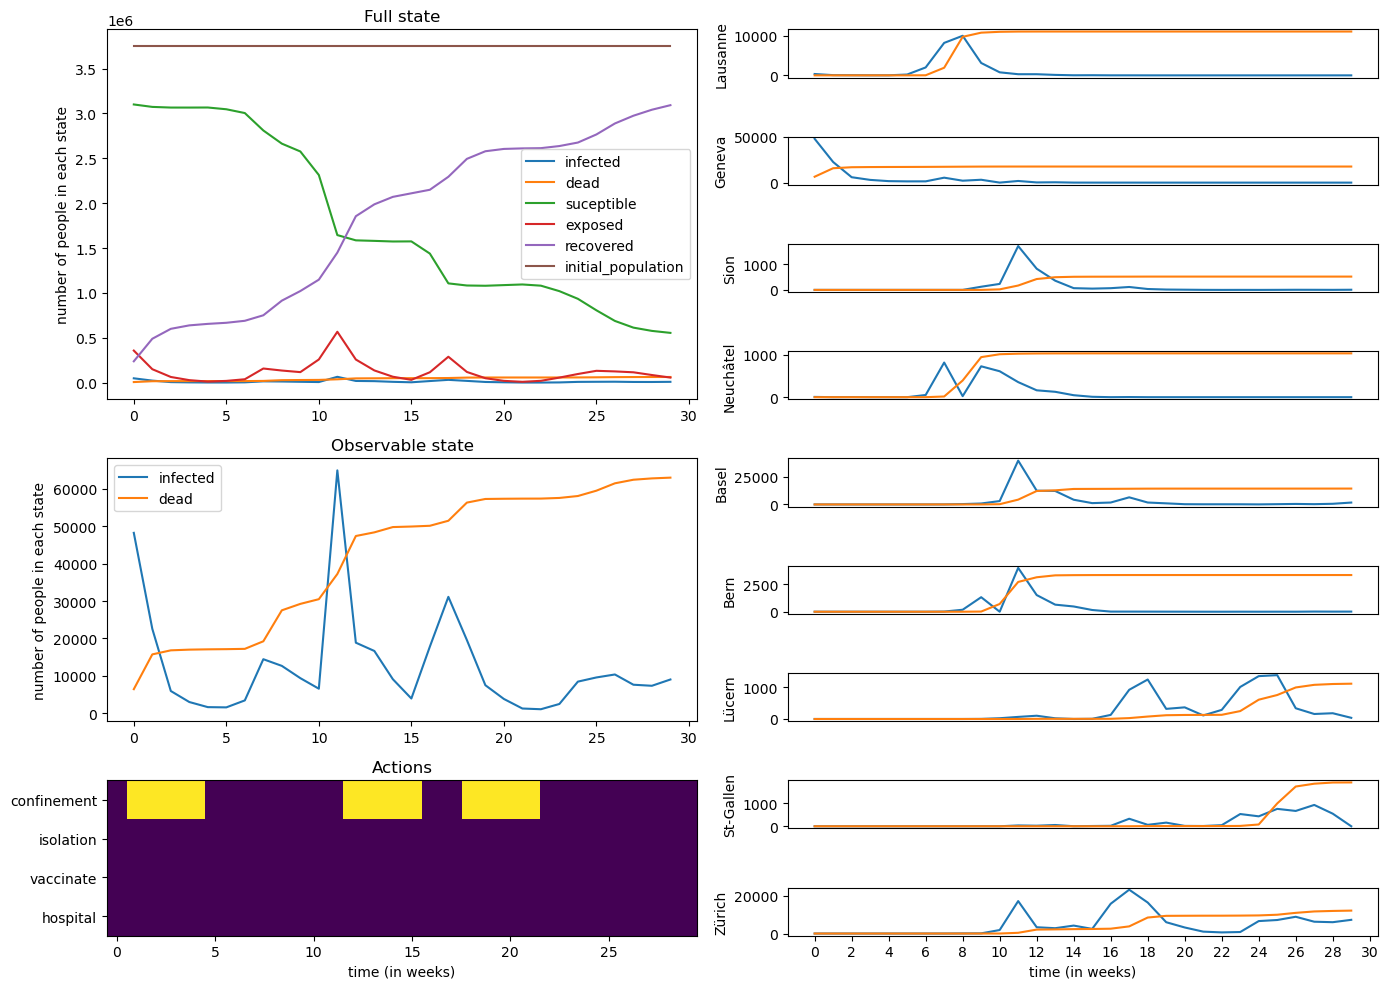

In [9]:
plot_info(total, cities, actions)

### Question 2.b: Evaluate Russo's Policy

In order to be able to make meaningful conclusions, we implement the following evaluation procedure: we run 50 simulation episodes where actions are chosen from Pr. Russo's Policy.

Notice that, to make results reproducible, we initialize one seed for every episode in the simulation: the i-th simulation corresponds to `seed = i`

In [10]:
# Initializing Russo Agent
agent = RussoAgent(env)
# Initializing the seeds for reproducibility purposes
seeds = range(1,51)

# Initializing useful variables to store results
conf_days = []
rewards = []
deaths = []

# Looping over 50 episodes
for trace in range(50): # for loop over episodes
    # Initializing provisional variable to save cumulative (non discounted) rewards
    R_cumulative = 0
    finished = False
    # Resetting the environment
    obs, info = env.reset(seeds[trace]) 
    # Synchronizing the agent with the newly defined environment
    agent.reset(env)
    
    # Looping over 30 weeks (lenght of one episode as defined in the pdf)
    for t in range(30):
        action = agent.act(info)
        obs, R, finished, info = env.step(action) 
        R_cumulative+= R.item()
        if finished:
            break
            
    """ Parse the logs """
    # Saving total number of confined days
    conf_days.append(7 * agent.confinement_weeks_count)
    # R_cumulative is computed in the inner loop
    rewards.append(R_cumulative)
    # Number of total deaths in the current episode
    deaths.append(info.total.dead)

We save the variables needed to later fill the table presenting the metrics used to compare the methods

In [11]:
conf_days_Russo = np.array(conf_days).mean()
rewards_Russo = np.array(rewards).mean()
deaths_Russo = np.array(deaths).mean()

print(conf_days_Russo, rewards_Russo, deaths_Russo)

98.98 -70.61567765619606 59053.52


We plot the histograms of the required quantities, in order to later compare the performance of this model with some more advanced Deep Reinforcement Learning Model.

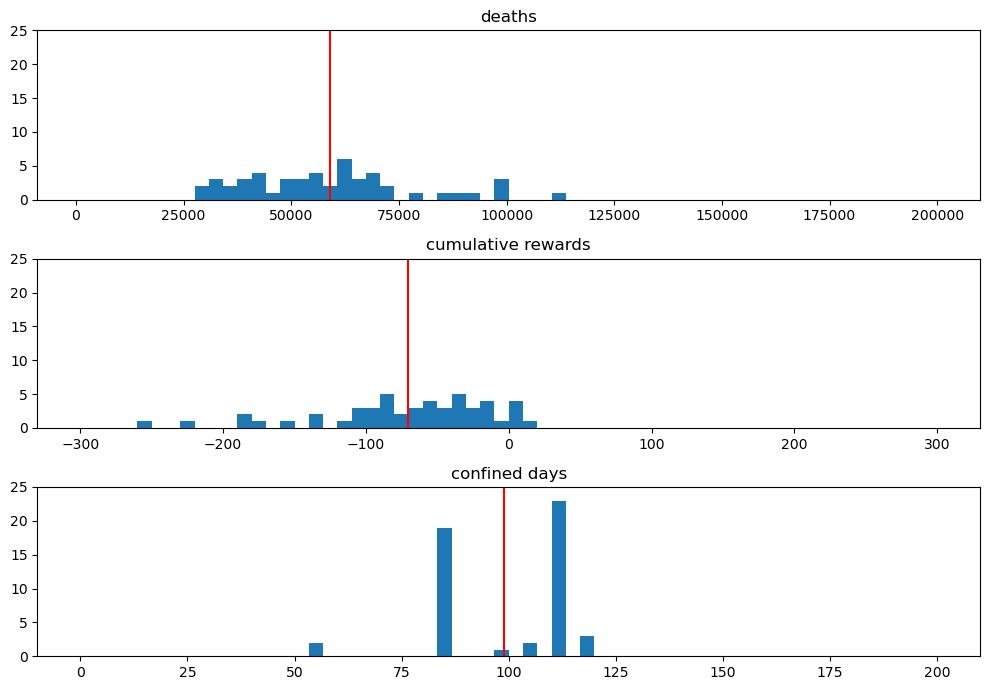

Average death number: 59053.52
Average number of confined days: 98.98
Average cumulative reward: -70.61567765619606


In [12]:
plot_histograms(deaths, rewards, conf_days)

## Prerequisites and needed data structures for the following tasks (Question 3 and 4)

In the following tasks, we are going to work with Deep Reinforcement Learning Models. In particular, despite some small variations regarding the action and observatin spaces, we are going to implement a DQN model.
It is therefore necessary to implement a memory buffer (to store transitions to be used during the off-policy update) and the general structure of the network we are going to use. Notice that all the technical choices, including the choice of hyperparameters, are taken following the suggestions provided by the teaching staff.

#### Initializing useful parameters

In [13]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
BATCH_SIZE = 2048
# GAMMA is the discount factor
GAMMA = 0.9
# EPS_START is the starting value of epsilon
EPS_START = 0.7
# EPS_END is the final value of epsilon (in case of decaying epsilon,meant to reduce the exploration)
EPS_MIN = 0.2 # same as EPS_START since we do not want to decrease it
# DECREASE_FLAG indicates whether we want to decrease the exploration
DECREASE_FLAG = False
# EXPLORATION_FLAG indicates whether we want to explore or not
EXPLORATION_FLAG = True
# LR is the learning rate of the AdamW optimizer
LR = 5e-3
# Update rate of the target network
TAU = 1

#### Memory Buffer

In order to save the transitions obtained from the interactions with the environment, we need to implement a Memory Buffer using a queue. To better deal with the data later, it is useful to assign a precise schema to each element of the buffer. This is achieved by defining the tuple scheme `Transition`

In [14]:
# The following is a named tuple representing a single transition in our environment
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# The following is a cyclic buffer of bounded size that holds the transitions observed recently. 
# It also implements a .sample() method for selecting a random batch of transitions for training.
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

#### Deep Q-Learning Network (DQN)

We define the network architecture we are going to use in the following tasks. The structure (layers) and the hyperparameters are chosen accordingly to the table provided in the pdf.

In [15]:
class DQN(torch.nn.Module):

    def __init__(self, n_observations, n_actions):
        super().__init__()
        
        # MLP network
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_observations, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),  
            torch.nn.Linear(16, n_actions)
        )
        
    # Called in order to compute the forward pass in the network
    def forward(self, x):
        # We flatten the input in order to use it in the linear network
        # Since we might end up having very small input values due to the scaling (see observation preprocessor),
        # we compute **(1/4) to increase the magnitude of each term (which is non negative by the dynamics of
        # the problem)
        new_x = torch.flatten(x,1) ** (1/4) 
        return self.mlp(new_x)

#### Defining a new Agent: `DQNAgent`

In order to interact with the environment, we define `DQNAgent` class. 

In [16]:
class DQNAgent(Agent): #superclass
    def __init__(self, env: Env, Net_Constructor, n_observations, n_actions):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        # MLP networks. Policy net and target net are used in order to compute the Qvalues
        self.policy_net = Net_Constructor(n_observations, n_actions).to(device)
        self.target_net = Net_Constructor(n_observations, n_actions).to(device)
        # We initialize the target network using the parameters of the policy network
        self.target_net.load_state_dict(self.policy_net.state_dict())
        # We initialize the optimizer using the suggeseted learning rate (it must act on policy_net parameters)
        self.optimizer = torch.optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True) # we initialize the optimizer
        self.env = env

        self.memory = ReplayMemory(20000)

    def load_model(self, PATH):
        """Routine for loading a pre-trained model"""
        self.policy_net.load_state_dict(PATH)
        pass

    def save_model(self, PATH):
        """Routine for saving the weights for a trained model"""
        torch.save(self.policy_net.state_dict(), PATH + '.pt')

    def optimize_model(self):
        
        """Routine to perform the optimization step updating policy net parameters"""
        
        # If there aren't enough data in the memory buffer, avoid computing update step
        if len(self.memory) < BATCH_SIZE:
            return
        
        # Sampling the transitions from the memory buffer
        transitions = self.memory.sample(BATCH_SIZE)
        # Transpose the batch. This converts batch-array of Transitions to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements, moving the final results to the device
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        
        # We save the non final state in our sampling
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        # We save and concatenate the variables we need
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            # we compute max_a Q(s', a) in order to quantify the delta. We use the target net to improve stability
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]
            
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        criterion = torch.nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        
        return
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
        
    def act(self, state, decrease_flag, exploration_flag, curr_episode):
        """ The following function defines the policy deployed in order to explore and interact with the environments.
            In particular, it is an epsilon greedy policy (if exploration_flag = True) based on the values provided by 
            the network trained up to this moment """
        
        # The method takes an observation and returns an action
        # In case of random action, the action can be directly sampled using self.env.action_space.sample()
        sample = random.random()

        # In case of decreasing exploration rate, the following variable is needed
        num_episodes = 500
        
        # Setting the epsilon parameter to have or avoid exploration
        if exploration_flag:
            if decrease_flag:
                eps_threshold = max(EPS_START*(num_episodes-curr_episode)/num_episodes, EPS_MIN)
            else:
                eps_threshold = EPS_START
        else:
            eps_threshold = 0 # in this case we only consider the greedy policy determined by the network
            
        if sample >= eps_threshold:
            with torch.no_grad():
                # We use torch.no_grad() since we are now using the network to simply take an action.
                # We do not need to expand the DAG and consider this computation in the backprop step.
                # We only consider the larger value to take the action.
                return self.policy_net(state).max(1)[1].view(1,1) # this format is needed to concatenate
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

## Question 3: Deep Q-Learning with a binary action space

### Question 3.a: Implementing Deep Q-Learning

Since the action space is binary and the observation space contains the measurement of the proportion of dead and infected people in each city, each day of a given week, we define action preprocessors and observation preprocessor to convert data from environment and neural network.

Action Preprocessor: the deafult action (Do Nothing) is encoded as 0, the CONFINEMENT action is encoded as 1.

We define it to convert the actions returned by the network to actions recognized by the environment

In [17]:
ACTION_NULL = 0
ACTION_CONFINE = 1

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False}
    
    # If a == 1 (the network returns 1), then do confinement
    if a == ACTION_CONFINE:
        action['confinement'] = True
        
    return action

Observation Preprocessor: every observation is converted to a tensor containing the proportion of death and infected people in each city.


Since the observation space contains the measurement of the proportion of dead and infected people in each city
we naively scale the observation space with SCALE = 1.

In [18]:
SCALE = 1
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

We now initialize the environment making sure to define the appropriate observation and action spaces. This is essential, since the action and observation format needed by the dynamic model is different from the encoding taken as input by the neural network we are going to train.

In [19]:
# Initializing the environment. Notice that it is essential to fix the seed for the gym action space
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.Discrete(2, seed=42) , # Here one could pass an openai gym action space that can then be sampled
            observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

We now initiliaze the models we need and other additional useful variables that will be used in the training and evaluation procedure.

In [20]:
# Training and evaluation parameters
num_episodes = 500
num_eval_episodes = 20
num_weeks = 30

# Initializing empty lists to save results
training = []
evaluation = []

# Initialize the directory to save the model and results of task 3.a
makedirs('./checkpoints_task3a', exist_ok=True)
rmtree('./checkpoints_task3a')
makedirs('./checkpoints_task3a')
PATH = './checkpoints_task3a/policy_net'

# We run the training and evaluation procedures 3 times, thus obtaining 3 different models. To analyse the
# performance of such approach, we are going to consider the best model among the obtained ones

for training_process in range(3):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process+1))

    # Ensuring reproducibility, making the net initialization deterministic
    # This line, together with the fact that the sedd og the gymnasium space is fixed, ensure
    # reproducibility
    torch.manual_seed(training_process)
    torch.use_deterministic_algorithms(True)
    
    # Initialize the agent for the current training_process
    agent = DQNAgent(env, Net_Constructor=DQN, n_observations=2*9*7, n_actions=2)
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []
    
    # Looping through the episodes (500 per training process)
    for i_episode in tqdm(range(num_episodes)):
        
        # if (i_episode % 10) == 0:
        #     print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0

        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*training_process + i_episode])
        state = torch.tensor(state, device=device)
        #print('state: ', state[0, 0, 5, 6])

        # We run an episode
        for t in range(num_weeks):

            action = agent.act(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
            #print(t, action)
            obs, reward, done, info = env.step(action.item())
            # print(reward)

            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)

            # Store the transition in memory (in the replay buffer)
            agent.memory.push(state, action, next_state, reward)
            
            # We run a training step on policy_net
            agent.optimize_model()

            # Move to the next state
            state = next_state

            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)


        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes (using a linear combination of the parameters)
            policy_net_state_dict = agent.policy_net.state_dict()
            target_net_state_dict = agent.target_net.state_dict()
            
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)

            # Changing the parameters of the target network
            agent.target_net.load_state_dict(target_net_state_dict)
            
        # If the following condition is satisfied, we compute an evaluation procedure
        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            # print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []
            
            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)

                for new_week in range(num_weeks):

                    action = agent.act(state, DECREASE_FLAG, False, new_episode) # greedy policy when eploration_flag = False
                    obs, reward, done, info = env.step(action.item())
                    total_eval_reward += reward.item()

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)

                    # Move to the next state
                    state = next_state

                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
            #print(eval_trace)
            #print(training_trace[-1])
            
    agent.save_model(PATH + str(training_process))        
    training.append(training_trace)
    evaluation.append(eval_trace)

print('Complete')


 TRAINING PROCESS :1 



 90%|████████▉ | 449/500 [03:44<00:25,  2.00it/s]


KeyboardInterrupt: 

We plot the results obtained during the training and evaluation procedures. Every figure corresponds to a different training procedure.

In [ ]:
plot_training_eval(training, evaluation)

We now proceed to load the best model among the 3. The choice is made depending on the last evaluation value that has been recorded for each process.

In [ ]:
# We select the best model after comparing the last evaluation entries for each training process
final_performance = np.array([evaluation[0][-1], evaluation[1][-1], evaluation[2][-1]])
best_model_idx = np.argmax(final_performance)

# We initialize a new network with the parameters of the best network
best_file = torch.load(PATH + str(best_model_idx) + '.pt')
best_agent_const = DQNAgent(env, DQN,n_observations=2*9*7, n_actions=2)
best_agent_const.policy_net.load_state_dict(best_file)

# We create a directory to save the model. This is useful in order not to run the whole training procedure again
makedirs('./checkpoints_final', exist_ok=True)
rmtree('./checkpoints_final')
makedirs('./checkpoints_final')
PATH = './checkpoints_final/task3a'

# Saving the model parameters
torch.save(best_agent_const.policy_net.state_dict(), PATH + '.pt')

We now proceed to simulate 3 episodes using the policy induced by the network. We then plot the results of one of these episodes to evaluate and discuss the effects of the policy.

In [ ]:
""" Run three simulation """
seeds = np.arange(42, 45)

log = []
    
agent = best_agent_const

for i_episode in range(3):

    episode_log = []
    
    # Initialize the environment and get its state (moving it to the device)
    state, info = env.reset(seeds[i_episode])
    episode_log.append(info)
    state = torch.tensor(state, device=device)

    # We run an episode
    for t in range(num_weeks):

        action = agent.act(state, DECREASE_FLAG, False, i_episode)
        obs, reward, done, info = env.step(action.item())
        episode_log.append(info)

        if done: # in our case it corresponds to 30 weeks
            next_state = None
        else:
            next_state = torch.tensor(obs, device=device)

        # Move to the next state
        state = next_state

        if done:
            break

    log.append(episode_log)

# computing useful quantities to then plot and visualize the effects of the network
total_secondepisode = {p:np.array([getattr(l.total,p) for l in log[1]]) for p in dyn.parameters}
cities_secondepisode = {c:{p:np.array([getattr(l.city[c],p) for l in log[1]]) for p in dyn.parameters} for c in dyn.cities}
actions_secondepisode = {a:np.array([l.action[a] for l in log[1]]) for a in log[1][0].action.keys()}

plot_info(total_secondepisode, cities_secondepisode, actions_secondepisode)

Moreover, we save the empirical results obtained in 50 episodes to later answer questions in section 5.

In [ ]:
PATH = './checkpoints_final/'
task_name = 'task3a'
best_file = torch.load(PATH + task_name + '.pt')

best_agent_SingleDQN = DQNAgent(env, DQN, n_observations=126, n_actions=2)
best_agent_SingleDQN.policy_net.load_state_dict(best_file)

conf_days_SingleDQN, isol_days_SingleDQN, vacc_days_SingleDQN, hosp_days_SingleDQN, rewards_SingleDQN, deaths_SingleDQN = evaluation_50_episodes(best_agent_SingleDQN,env,device,dyn)

avg_conf_SingleDQN = np.array(conf_days_SingleDQN).mean()
avg_isol_SingleDQN = np.array(isol_days_SingleDQN).mean()
avg_vacc_SingleDQN = np.array(vacc_days_SingleDQN).mean()
avg_hosp_SingleDQN = np.array(hosp_days_SingleDQN).mean()

In [ ]:
avg_conf_SingleDQN

### Question 3.b: decreasing exploration

In [ ]:
# DECREASE_FLAG indicates whether we want to decrease the exploration
DECREASE_FLAG = True

Now we can implement a different exploration policy by adjusting some parameters. 

In particular, we want to implement a decrease in the exploration threshold.
This is done to advantage exploration over exploitation in the first stage of the training process, in order to speed up the learning process. The deeper we go in the training, the more information we have about the environment and the transitions, therefore we decrease the exploration coefficient in order to take advantage of exploitation. 

In [ ]:
# Training and evaluation parameters
num_episodes = 500
num_eval_episodes = 20
num_weeks = 30


# Initializing empty lists to save results
training = []
training_weights = []
evaluation = []

# Initialize the directory to save the model and results of task 3.b
makedirs('./checkpoints_task3b', exist_ok=True)
rmtree('./checkpoints_task3b')
makedirs('./checkpoints_task3b')
PATH = './checkpoints_task3b/policy_net'

# We run the training and evaluation procedures 3 times, thus obtaining 3 different models. To analyse the
# performance of such approach, we are going to consider the best model among the obtained ones
for training_process in range(3):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process+1))
    
    torch.manual_seed(training_process)
    torch.use_deterministic_algorithms(True)
    
    agent = DQNAgent(env, Net_Constructor=DQN, n_observations=2*9*7, n_actions=2)
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []
    
    # Looping through the episodes (500 per training process)
    for i_episode in tqdm(range(num_episodes)):
        
        # if (i_episode % 10) == 0:
        #     print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0
        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*training_process + i_episode])
        state = torch.tensor(state, device=device)

        # We run an episode
        for t in range(num_weeks):

            action = agent.act(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
            obs, reward, done, info = env.step(action.item())

            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)

            # Store the transition in memory (in the replay buffer)
            agent.memory.push(state, action, next_state, reward)
            
            # We run a training step on policy_net
            agent.optimize_model()

            # Move to the next state
            state = next_state

            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)


        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes
            policy_net_state_dict = agent.policy_net.state_dict()
            agent.target_net.load_state_dict(policy_net_state_dict)

        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            # print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []

            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)

                for new_week in range(num_weeks):

                    action = agent.act(state, DECREASE_FLAG, False, new_episode) # greedy policy when eploration_flag = False
                    obs, reward, done, info = env.step(action.item())
                    total_eval_reward += reward.item()

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)

                    # Move to the next state
                    state = next_state

                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
    
    agent.save_model(PATH + str(training_process))        
    training.append(training_trace)
    evaluation.append(eval_trace)

print('Complete')

We plot the obtained results to discuss the effects of the policy.

In [ ]:
plot_training_eval(training, evaluation)

In [ ]:
evaluation

We now proceed to load the best model among the 3. The choice is made depending on the last evaluation value that has been recorded for each process.

In [ ]:
# We select the best model after comparing the last evaluation entries for each training process
final_performance = np.array([evaluation[0][-1], evaluation[1][-1], evaluation[2][-1]])
best_model_idx = np.argmax(final_performance)

# We initialize a new network with the parameters of the best network
best_file = torch.load(PATH + str(best_model_idx) + '.pt')
best_agent_decreasing = DQNAgent(env, DQN,n_observations=2*9*7, n_actions=2)
best_agent_decreasing.policy_net.load_state_dict(best_file)

# We save the model. This is useful in order not to run the whole training procedure again
PATH = './checkpoints_final/task3b'
torch.save(best_agent_decreasing.policy_net.state_dict(), PATH + '.pt')

We now proceed to simulate 3 episodes using the policy induced by the network. We then plpot the results of one of these episodes to evaluate and discuss the effects of the policy.

In [ ]:
""" Run three simulation """
seeds = np.arange(42, 45)

log = []
    
agent = best_agent_decreasing

for i_episode in range(3):

    episode_log = []
    
    # Initialize the environment and get its state (moving it to the device)
    state, info = env.reset(seeds[i_episode])
    episode_log.append(info)
    state = torch.tensor(state, device=device)

    # We run an episode
    for t in range(num_weeks):

        action = agent.act(state, DECREASE_FLAG, False, i_episode)
        obs, reward, done, info = env.step(action.item())
        episode_log.append(info)

        if done: # in our case it corresponds to 30 weeks
            next_state = None
        else:
            next_state = torch.tensor(obs, device=device)

        # Move to the next state
        state = next_state

        if done:
            break

    log.append(episode_log)

total_secondepisode = {p:np.array([getattr(l.total,p) for l in log[2]]) for p in dyn.parameters}
cities_secondepisode = {c:{p:np.array([getattr(l.city[c],p) for l in log[2]]) for p in dyn.parameters} for c in dyn.cities}
actions_secondepisode = {a:np.array([l.action[a] for l in log[1]]) for a in log[2][0].action.keys()}

plot_info(total_secondepisode, cities_secondepisode, actions_secondepisode)

Moreover, we save the empirical results obtained in 50 episodes to later answer questions in section 5.

In [ ]:
PATH = './checkpoints_final/'
task_name = 'task3b'
best_file = torch.load(PATH + task_name + '.pt')

best_agent_SingleDQN_decreasing = DQNAgent(env, DQN, n_observations=126, n_actions=2)
best_agent_SingleDQN_decreasing.policy_net.load_state_dict(best_file)

conf_days_SingleDQN_decreasing, isol_days_SingleDQN_decreasing, vacc_days_SingleDQN_decreasing,hosp_days_SingleDQN_decreasing, rewards_SingleDQN_decreasing, deaths_SingleDQN_decreasing = evaluation_50_episodes(best_agent_SingleDQN_decreasing,env,device,dyn)

avg_conf_SingleDQN_decreasing = np.array(conf_days_SingleDQN_decreasing).mean()
avg_isol_SingleDQN_decreasing = np.array(isol_days_SingleDQN_decreasing).mean()
avg_vacc_SingleDQN_decreasing = np.array(vacc_days_SingleDQN_decreasing).mean()
avg_hosp_SingleDQN_decreasing = np.array(hosp_days_SingleDQN_decreasing).mean()
avg_rewards_SingleDQN_decreasing = np.array(rewards_SingleDQN_decreasing).mean()
avg_deaths_SingleDQN_decreasing = np.array(deaths_SingleDQN_decreasing).mean()


### Question 3.c: Evaluate the best performing policy against Pr. Russo’s policy

We plot the histograms of the required quantities.

In [ ]:
plot_histograms(deaths_SingleDQN_decreasing, rewards_SingleDQN_decreasing, conf_days_SingleDQN_decreasing)

## Question 4: Dealing with a more complex action Space

In order to answer the questions of this task, we are asked to use 10e-5 as a learning rate. Therefore, we set this new value in the next cell.

In [ ]:
# Learning Rate
LR = 10e-5

Moreover, despite the changes we need to make for what regards the action and observation spaces, the structure (architecture) of the agent is unchanged for now. Therefore, in this first part, we will use the above defined class `DQN`, this time initialized using `n_action` = 5.

## Question 4.1: Action space design

### Question 4.1.b: Toggle-action-space multi-action policy training

After discussing how the new choice of action and observation space affects the network architecture, we proceed to implement the toggled-action and observation spaces to train the Deep Q-Learning agent.

For what regards the action space, since we are only allowed to toggle, we can still consider the action to be a scalar indicating for which action we need to change the state (from True to False, from activated to deactivated).

In [ ]:
# Action Preprocessor: the deafult action (Do Nothing) is encoded as 0
# All the remaining actions are encoded as a single number

TOGGLE_NULL = 0
TOGGLE_CONFINEMENT = 1
TOGGLE_ISOLATION = 2
TOGGLE_HOSPITAL = 3
TOGGLE_VACCINATION = 4

def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    
    # As described above, the input argument a corresponds to a scalar, indicating which 
    # action has to be toggled
    
    default_action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False}
    
    if a not in range(0, 5):
        print('Not a valid action!')
        return default_action
    
    
    # We get the state of the actions used in the past week. Starting from this configuration,
    # we toggle the action according to the information carried by the input argument a
    action = dyn.get_action()
    
    if a == TOGGLE_NULL: 
        return action
    elif a == TOGGLE_CONFINEMENT:
        action['confinement'] = not action['confinement'] 
    elif a == TOGGLE_ISOLATION:
        action['isolation'] = not action['isolation']
    elif a == TOGGLE_HOSPITAL:
        action['hospital'] = not action['hospital']
    else: 
        action['vaccinate'] = not action['vaccinate']
    
    return action

# Observation Preprocessor: every observation is converted to a tensor containing the proportion of death and
# infected people in each city. Since we need to consider also the actions' states, we eventually return a 
# tensor of shape (1,130) as a result of the flattining operation and the concatenation

SCALE = 1
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    
    curr_action = torch.Tensor(4)
    curr_action[0] = 1 if dyn.get_action()['confinement'] else 0
    curr_action[1] = 1 if dyn.get_action()['isolation'] else 0
    curr_action[2] = 1 if dyn.get_action()['hospital'] else 0
    curr_action[3] = 1 if dyn.get_action()['vaccinate'] else 0
    
    ret = torch.flatten(torch.Tensor(np.stack((infected, dead))).unsqueeze(0),1)
    ret = torch.cat([ret, curr_action.unsqueeze(dim=0)], dim=1) # shape (1,130)
    
    return ret

Since we have defined a new action and observation spaces, as well as new preprocessors, we need to redefine the environment we are going to interact with.

In [ ]:
# Initializing the environment
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.Discrete(5,seed=42) , # Since we can toggle 1 out of 4 actions, or DO NOTHING
            # observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

# Save an environment for later comparison (check Q values heatmpao in task 5)
env_toggle = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.Discrete(5, seed=42) , # Since we can toggle 1 out of 4 actions, or DO NOTHING
            # observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

We now compute three training processes, in order to then plot the average training and evaluation results.

In [ ]:
# Initializing episode and training length
num_episodes = 500
num_eval_episodes = 20
num_weeks = 30

training = []
training_weights = []
evaluation = []

makedirs('./checkpoints_task4a', exist_ok=True)
rmtree('./checkpoints_task4a')
makedirs('./checkpoints_task4a')
PATH = './checkpoints_task4a/policy_net'

n_observations = 2*9*7 + 4
n_actions = 5

for training_process in range(3):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process+1))
    
    torch.manual_seed(training_process)
    torch.use_deterministic_algorithms(True)
    
    agent = DQNAgent(env, Net_Constructor=DQN, n_observations= n_observations, n_actions=n_actions)
    # memory = ReplayMemory(20000) # we initialize the buffer from which we sample already observed transitions
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []

    for i_episode in tqdm(range(num_episodes)):
        
        # if (i_episode % 10) == 0:
        #     print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0
        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*training_process + i_episode])
        state = torch.tensor(state, device=device)

        # We run an episode
        for t in range(num_weeks):

            action = agent.act(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode)
            obs, reward, done, info = env.step(action.item())

            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)

            # Store the transition in memory (in the replay buffer)
            agent.memory.push(state, action, next_state, reward)
            
            # We run a training step on policy_net
            agent.optimize_model()

            # Move to the next state
            state = next_state

            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)

        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes
            policy_net_state_dict = agent.policy_net.state_dict()
            agent.target_net.load_state_dict(policy_net_state_dict)

        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            # print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []

            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)

                for new_week in range(num_weeks):

                    action = agent.act(state, DECREASE_FLAG, False, new_episode) # greedy policy when eploration_flag = False
                    obs, reward, done, info = env.step(action.item())
                    total_eval_reward += reward.item()

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)

                    # Move to the next state
                    state = next_state

                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
    
    agent.save_model(PATH + str(training_process))        
    training.append(training_trace)
    evaluation.append(eval_trace)

print('Complete')

After computing and logging the results, we plot and visualize them.

In [ ]:
plot_training_eval(training, evaluation)

In [ ]:
evaluation

In order to later compare the toggle action space with the factorized Q values architecture, we now save the obtained evaluation and training traces in helper variables.

In [ ]:
toggle_evaluation = evaluation
toggle_training = training

After choosing the best model, we run 3 episodes and plot the results of one of them.

We now observe the performance of the best model.

In [ ]:
final_performance = np.array([evaluation[0][-1], evaluation[1][-1], evaluation[2][-1]])
best_model_idx = np.argmax(final_performance)

best_file = torch.load(PATH + str(best_model_idx) + '.pt')
best_agent_toggle = DQNAgent(env, DQN,n_observations=n_observations, n_actions=n_actions)
best_agent_toggle.policy_net.load_state_dict(best_file)

PATH = './checkpoints_final/task4a'

torch.save(best_agent_toggle.policy_net.state_dict(), PATH + '.pt')

In [ ]:
""" Run three simulation """
seeds = np.arange(42, 45)

log = []
    
agent = best_agent_toggle

for i_episode in range(3):

    episode_log = []
    
    # Initialize the environment and get its state (moving it to the device)
    state, info = env.reset(seeds[i_episode])
    episode_log.append(info)
    state = torch.tensor(state, device=device)

    # We run an episode
    for t in range(num_weeks):

        action = agent.act(state, DECREASE_FLAG, False, i_episode)
        obs, reward, done, info = env.step(action.item())
        episode_log.append(info)

        if done: # in our case it corresponds to 30 weeks
            next_state = None
        else:
            next_state = torch.tensor(obs, device=device)

        # Move to the next state
        state = next_state

        if done:
            break

    log.append(episode_log)

total_secondepisode = {p:np.array([getattr(l.total,p) for l in log[1]]) for p in dyn.parameters}
cities_secondepisode = {c:{p:np.array([getattr(l.city[c],p) for l in log[1]]) for p in dyn.parameters} for c in dyn.cities}
actions_secondepisode = {a:np.array([l.action[a] for l in log[1]]) for a in log[1][0].action.keys()}

plot_info(total_secondepisode, cities_secondepisode, actions_secondepisode)

### Question 4.1.c: Toggle-action-space multi-action policy evaluation

As we previously did for Russo's policy, we proceed to plot 50 episodes to then visualize the results using the plot histograms function provided.

In [ ]:
PATH = './checkpoints_final/'
task_name = 'task4a'
best_file = torch.load(PATH + task_name + '.pt')

best_agent_toggle = DQNAgent(env, DQN, n_observations=130, n_actions=5)
best_agent_toggle.policy_net.load_state_dict(best_file)

conf_days_toggle, isol_days_toggle, vacc_days_toggle, hosp_days_toggle, rewards_toggle, deaths_toggle = evaluation_50_episodes(best_agent_toggle,env,device,dyn)

avg_conf_toggle = np.array(conf_days_toggle).mean()
avg_isol_toggle = np.array(isol_days_toggle).mean()
avg_vacc_toggle = np.array(vacc_days_toggle).mean()
avg_hosp_toggle = np.array(hosp_days_toggle).mean()
avg_rewards_toggle = np.array(rewards_toggle).mean()
avg_deaths_toggle = np.array(deaths_toggle).mean()

print(avg_conf_toggle, avg_isol_toggle, avg_vacc_toggle, avg_hosp_toggle, avg_rewards_toggle, avg_deaths_toggle)

We plot the histograms of the required quantities.

In [ ]:
plot_histograms(deaths_toggle, rewards_toggle, conf_days_toggle)

## 4.2 Factorized Q-values, multi-action agent

### Question 4.2.a: Multi-action factorized Q-values policy training

Instead of implementing a toggled behavior as above you let the neural network decide whether to make each decision True or False independently. For this purpose, we need to change the action preprocessor and the observation preprocessor, as well as the spaces.

In [ ]:
# Learning Rate (we use the one suggested in the pdf)
LR = 10e-5

In [ ]:
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    
    # a is a pytorch tensor of shape (1,4)
    
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False}
    
    action['confinement'] = bool(a[0][0])
    action['isolation'] = bool(a[0][1])
    action['hospital'] = bool(a[0][2])
    action['vaccinate'] = bool(a[0][3])
    
    return action

# Observation Preprocessor: every observation is converted to a tensor containing the proportion of death and
# infected people in each city

SCALE = 1
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

We now initialize a new environment, giving the new preprocessors defined above as input arguments.

In [ ]:
# Initializing the environment
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.MultiBinary([1,4], seed=42) , # Here one could pass an openai gym action space that can then be sampled
            observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

# Saving a model for later comparison
env_factorized = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=spaces.MultiBinary([1,4], seed=42) , # Here one could pass an openai gym action space that can then be sampled
            observation_space=spaces.Box(low=0, high=1, shape=(2,9,7)),
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor)

Because we now allow the agent to take 16 actions (True or False for every one of the four actions), we also need to change the architecture of the neural network we use as an agent. We put particular attention on the output layer, which now returns a tensor of shape (4,2). Every row now represents and action, and every column indicates whether we take (col_id = 1) or not (col_id = 0) that specific action. In order to define the action to take after computing the output value, we need to compute, for each row of the output tensor, the argmax between the values.

In [ ]:
class DQN_task4(torch.nn.Module):

    def __init__(self, n_observations, n_actions):
        super().__init__()
        
        # MLP network
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(n_observations, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),  
            torch.nn.Linear(16, n_actions) # here n agent is set to 8
        )
        
    # Called in order to compute the forward pass in the network
    def forward(self, x):
        new_x = torch.flatten(x,1) ** (1/4) # since we might end up having very small input values due to the scaling
                                            # We flatten the input in order to use it in the linear network
        z = self.mlp(new_x)
        
        return torch.reshape(z, (-1,4,2))

We now redefine the agent class, using the above defined constructor in order to define and initialize both the policy and the target networks.

In [ ]:
class DQNAgentTotal(Agent): #superclass
    def __init__(self, env: Env, Net_Constructor, n_observations, n_actions):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        # MLP networks. Policy net and target net are used in order to compute the Qvalues
        self.policy_net = Net_Constructor(n_observations, n_actions).to(device)
        self.target_net = Net_Constructor(n_observations, n_actions).to(device)
        # We initialize the target network using the parameters of the policy network
        self.target_net.load_state_dict(self.policy_net.state_dict())
        # We initialize the optimizer using the suggeseted learning rate (it must act on policy_net parameters)
        self.optimizer = torch.optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True) # we initialize the optimizer
        self.env = env

        self.memory = ReplayMemory(20000)

    def load_model(self, PATH):
        """Routine for loading a pre-trained model"""
        self.policy_net.load_state_dict(PATH)
        pass

    def save_model(self, PATH):
        """Routine for saving the weights for a trained model"""
        torch.save(self.policy_net.state_dict(), PATH + '.pt')

    def optimize_model(self):
        
        """Routine to perform the optimization step updating policy net parameters"""
        
        # If there aren't enough data in the memory buffer, avoid computing update step
        if len(self.memory) < BATCH_SIZE:
            return
        
        # Sampling the transitions from the memory buffer
        transitions = self.memory.sample(BATCH_SIZE)
        # Transpose the batch. This converts batch-array of Transitions to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements, moving the final results to the device
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
        
        # We save the non final state in our sampling
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        # We save and concatenate the variables we need
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_net(state_batch)
        state_action_values = torch.sum(state_action_values.gather(2, action_batch.unsqueeze(2)), dim=1)
        
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        with torch.no_grad():
            # we compute max_a Q(s', a) in order to quantify the delta. We use the target net to improve stability
            next_state_values[non_final_mask] = torch.sum(self.target_net(non_final_next_states).max(2)[0], dim=1)
            
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

        # Compute Huber loss
        criterion = torch.nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
        
        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
        
    def act(self, state, decrease_flag, exploration_flag, curr_episode):
        """ The following function defines the policy deployed in order to explore and interact with the environments.
            In particular, it is an epsilon greedy policy (if exploration_flag = True) based on the values provided by 
            the network trained up to this moment """
        
        # The method takes an observation and returns an action
        # In case of random action, the action can be directly sampled using self.env.action_space.sample()
        sample = random.random()

        # In case of decreasing exploration rate, the following variable is needed
        num_episodes = 500
        
        # Setting the epsilon parameter to have or avoid exploration
        if exploration_flag:
            if decrease_flag:
                eps_threshold = max(EPS_START*(num_episodes-curr_episode)/num_episodes, EPS_MIN)
            else:
                eps_threshold = EPS_START
        else:
            eps_threshold = 0 # in this case we only consider the greedy policy determined by the network
            
        if sample >= eps_threshold:
            with torch.no_grad():
                # We use torch.no_grad() since we are now using the network to simply take an action.
                # We do not need to expand the DAG and consider this computation in the backprop step.
                # We only consider the larger value to take the action.
                return self.policy_net(state).max(2)[1]
        else:
            return torch.tensor(agent.env.action_space.sample(), device=device, dtype=torch.long)

We now run the training procedure.

In [ ]:
# Initializing episode and training length
num_episodes = 500
num_eval_episodes = 20
num_weeks = 30

training = []
training_weights = []
evaluation = []

makedirs('./checkpoints_task4b', exist_ok=True)
rmtree('./checkpoints_task4b')
makedirs('./checkpoints_task4b')
PATH = './checkpoints_task4b/policy_net'

n_observations = 2*9*7
n_actions = 8

for training_process in range(3):
    
    print('\n TRAINING PROCESS :{} \n'.format(training_process+1))
    
    torch.manual_seed(training_process)
    torch.use_deterministic_algorithms(True)
    
    agent = DQNAgentTotal(env, Net_Constructor=DQN_task4, n_observations= n_observations, n_actions=n_actions)
    # memory = ReplayMemory(20000) # we initialize the buffer from which we sample already observed transitions
    
    # Initialize list to keep trace of log rewards
    training_trace = []
    eval_trace = []

    for i_episode in tqdm(range(num_episodes)):
        
        # if (i_episode % 10) == 0:
        #     print('Training episode :{}'.format(i_episode))

        # Initialize variable to keep trace of the total reward
        total_training_reward = 0
        # Initialize the environment and get its state (moving it to the device)
        state, info = env.reset(training_seeds[500*training_process + i_episode])
        state = torch.tensor(state, device=device)

        # We run an episode
        for t in range(num_weeks):

            action = agent.act(state, DECREASE_FLAG, EXPLORATION_FLAG, i_episode) # tensor of shape (1, 1, 4)
            
            obs, reward, done, info = env.step(action)

            total_training_reward += reward.item()
            reward = torch.tensor([reward], device=device)

            if done: # in our case it corresponds to 30 weeks
                next_state = None
            else:
                next_state = torch.tensor(obs, device=device)

            # Store the transition in memory (in the replay buffer)
            agent.memory.push(state, action, next_state, reward)
            
            # We run a training step on policy_net
            agent.optimize_model()

            # Move to the next state
            state = next_state

            if done:
                break

        # We log the cumulative reward to training trace
        training_trace.append(total_training_reward)

        if ((i_episode + 1) % 5 == 0):

            # We update the target network every 5 epsiodes
            policy_net_state_dict = agent.policy_net.state_dict()
            agent.target_net.load_state_dict(policy_net_state_dict)

        if ((i_episode + 1) % 50 == 0) or ((i_episode + 1) == 500):

            # print('Evaluation cycle: {}'.format(int((i_episode + 1) / 50)))
            average_rewards = []

            for new_episode in range(num_eval_episodes):

                total_eval_reward = 0
                state, info = env.reset(eval_seeds[new_episode])
                state = torch.tensor(state, device=device)

                for new_week in range(num_weeks):

                    action = agent.act(state, DECREASE_FLAG, False, new_episode) # greedy policy when eploration_flag = False
                    obs, reward, done, info = env.step(action)
                    total_eval_reward += reward.item()

                    if done: # in our case it corresponds to 30 weeks
                        next_state = None
                    else:
                        next_state = torch.tensor(obs, device=device)

                    # Move to the next state
                    state = next_state

                    if done:
                        break

                average_rewards.append(total_eval_reward)

            eval_trace.append(np.mean(average_rewards))
    
    agent.save_model(PATH + str(training_process))        
    training.append(training_trace)
    evaluation.append(eval_trace)

print('Complete')

In [ ]:
evaluation

We plot the training and evaluation traces directly comparing them to the toggle case.

In [ ]:
plot_comparison_toggle_factorized(toggle_training, toggle_evaluation, training, evaluation)

We now load the best model according to the perfomance logged during the evaluation phase.

In [ ]:
final_performance = np.array([evaluation[0][-1], evaluation[1][-1], evaluation[2][-1]])
best_model_idx = np.argmax(final_performance)

best_file = torch.load(PATH + str(best_model_idx) + '.pt')
best_agent_factorized = DQNAgentTotal(env, DQN_task4, n_observations=n_observations, n_actions=n_actions)
best_agent_factorized.policy_net.load_state_dict(best_file)

PATH = './checkpoints_final/task4b'

torch.save(best_agent_factorized.policy_net.state_dict(), PATH + '.pt')

We simulate 3 episodes and plot one of them.

In [ ]:
""" Run three simulation """
seeds = np.arange(42, 45)

log = []
    
agent = best_agent_factorized

for i_episode in range(3):

    episode_log = []
    
    # Initialize the environment and get its state (moving it to the device)
    state, info = env.reset(seeds[i_episode])
    episode_log.append(info)
    state = torch.tensor(state, device=device)

    # We run an episode
    for t in range(num_weeks):

        action = agent.act(state, DECREASE_FLAG, False, i_episode)
        obs, reward, done, info = env.step(action)
        episode_log.append(info)

        if done: # in our case it corresponds to 30 weeks
            next_state = None
        else:
            next_state = torch.tensor(obs, device=device)

        # Move to the next state
        state = next_state

        if done:
            break

    log.append(episode_log)

total_secondepisode = {p:np.array([getattr(l.total,p) for l in log[1]]) for p in dyn.parameters}
cities_secondepisode = {c:{p:np.array([getattr(l.city[c],p) for l in log[1]]) for p in dyn.parameters} for c in dyn.cities}
actions_secondepisode = {a:np.array([l.action[a] for l in log[1]]) for a in log[1][0].action.keys()}

plot_info(total_secondepisode, cities_secondepisode, actions_secondepisode)

### Task 4.2.b

Simulating 50 episodes to then plot the histogram and do the comparisons.

In [ ]:
conf_days_factorized, isol_days_factorized, vacc_days_factorized, hosp_days_factorized, rewards_factorized, deaths_factorized = evaluation_50_episodes_factorized(best_agent_factorized,env,device,dyn)

avg_conf_factorized = np.array(conf_days_factorized).mean()
avg_isol_factorized = np.array(isol_days_factorized).mean()
avg_vacc_factorized = np.array(vacc_days_factorized).mean()
avg_hosp_factorized = np.array(hosp_days_factorized).mean()
avg_rewards_factorized = np.array(rewards_factorized).mean()
avg_deaths_factorized = np.array(deaths_factorized).mean()

print(avg_conf_factorized, avg_isol_factorized, avg_vacc_factorized, avg_hosp_factorized, avg_rewards_factorized, avg_deaths_factorized)

In [ ]:
plot_histograms(deaths_factorized, rewards_factorized, conf_days_factorized)

### Task 5b: Comparing policies

### 5c: Heatmap Q-values

We now plot the Q values for the networks implemented in the factorized and toggle case.

In [ ]:
action_names = ['Do Nothing', 'Toggle Confinment', 'Toggle Isolation', 'Toggle Hospital', 'Toggle Vaccination']
heatmap(best_agent_toggle, 5, action_names, 'Toggle Action', env_toggle)

In [ ]:
action_names = ['Do Nothing','Toggle Confinment','Toggle Isolation','Toggle Hospital','Toggle Vaccination']
heatmap(best_agent_factorized, 8, action_names, 'Factorized Q Values', env_factorized, factorized = True)